
数据已保存到：/Users/rbw/Desktop/Q2_result.csv

Stock 600030 on 2020-12-02:
              sym       date                time  intraday_volatility  \
1098  600030.SHSE 2020-12-02 2025-02-19 09:30:00             0.011137   
1099  600030.SHSE 2020-12-02 2025-02-19 09:35:00             0.007733   
1100  600030.SHSE 2020-12-02 2025-02-19 09:40:00             0.007379   
1101  600030.SHSE 2020-12-02 2025-02-19 09:45:00             0.008113   
1102  600030.SHSE 2020-12-02 2025-02-19 09:50:00             0.012692   

      spread_bps      qsize    volpct                 date-time  
1098    5.031604  39541.575  0.071296 2020-12-02 09:30:00-19:00  
1099    4.447903  28341.440  0.059126 2020-12-02 09:35:00-19:00  
1100    4.077566  34160.015  0.042605 2020-12-02 09:40:00-19:00  
1101    5.131609  27110.240  0.026379 2020-12-02 09:45:00-19:00  
1102    5.461730  16029.920  0.030159 2020-12-02 09:50:00-19:00  


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


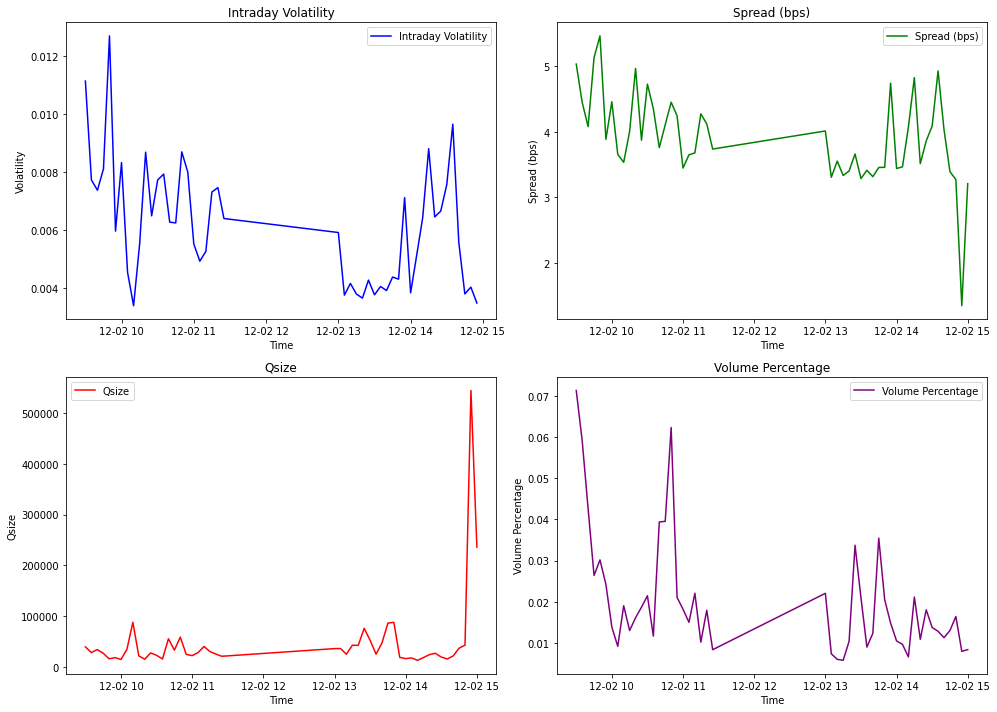

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 加载数据
trade = pd.read_csv(' ', parse_dates=['date'])
quote = pd.read_csv(' ', parse_dates=['date'])

### Quote 文件处理
# 计算报价数据的价差和平均挂单量
quote['spread_bps'] = 10000 * (quote['ask'] - quote['bid']) / ((quote['ask'] + quote['bid']) / 2)
quote['qsize'] = (quote['asize'] + quote['bsize']) / 2

# 添加时间列（直接按5分钟分桶）
quote['time'] = pd.to_datetime(quote['time'])
quote['5min_bucket'] = quote['time'].dt.floor('5T')  # 按5分钟分桶

# 按5分钟分组计算平均价差和平均挂单量
quote_5m = quote.groupby(['sym', 'date', '5min_bucket']).agg(
    spread_bps=('spread_bps', 'mean'),  # 5分钟平均价差
    qsize=('qsize', 'mean')             # 5分钟平均挂单量
).reset_index()

### Trade 文件处理
# 计算每天的成交量
daily_volume = trade.groupby(['sym', 'date'])['size'].sum().reset_index(name='daily_volume')
trade = pd.merge(trade, daily_volume, on=['sym', 'date'], how='left')

# 计算每行的收益率
trade['rtn'] = trade.groupby('sym')['price'].pct_change()

# 按5分钟分桶
trade['time'] = pd.to_datetime(trade['time'])
trade['5min_bucket'] = trade['time'].dt.floor('5T')

# 计算每天的交易分钟数
trade['minute'] = trade['time'].dt.floor('T')  # 按分钟分桶
daily_minutes = trade.groupby(['sym', 'date'])['minute'].nunique().reset_index(name='daily_minutes')
trade = pd.merge(trade, daily_minutes, on=['sym', 'date'], how='left')

# 按5分钟分组计算每组的成交量占比和波动率
trade_5m = trade.groupby(['sym', 'date', '5min_bucket']).agg(
    volume_sum=('size', 'sum'),  # 每组的成交量之和
    rtn_std=('rtn', 'std'),      # 每组收益率的标准差
    daily_minutes=('daily_minutes', 'first')  # 每天的交易分钟数
).reset_index()

# 计算每组的成交量占比
trade_5m['volpct'] = trade_5m['volume_sum'] / trade_5m.groupby(['sym', 'date'])['volume_sum'].transform('sum')

# 计算每组的波动率（根据每天的交易分钟数调整年化因子）
trade_5m['intraday_volatility'] = trade_5m['rtn_std'] * np.sqrt(trade_5m['daily_minutes'])

### 合并处理后的 trade 和 quote 文件
# 合并 trade_5m 和 quote_5m
merged_data = pd.merge(
    trade_5m[['sym', 'date', '5min_bucket', 'intraday_volatility', 'volpct']],
    quote_5m[['sym', 'date', '5min_bucket', 'spread_bps', 'qsize']],
    on=['sym', 'date', '5min_bucket'],
    how='inner'
)

# 重命名时间列为 time
merged_data = merged_data.rename(columns={'5min_bucket': 'time'})

# 按需要的字段排序
merged_data = merged_data[['sym', 'date', 'time', 'intraday_volatility', 'spread_bps', 'qsize', 'volpct']]

#将合并的数据存于
merged_data.to_csv('/Users/rbw/Desktop/Q2_result.csv', index=False)
print("\n数据已保存到：/Users/rbw/Desktop/Q2_result.csv")

# 筛选股票代码为 600030 且日期为 2020-12-02 的数据
stock_data = merged_data[
    (merged_data['sym'] == '600030.SHSE') & 
    (merged_data['date'] == '2020-12-02')
]

# 合并 date 和 time 列为 date-time
stock_data['date-time'] = stock_data['date'].astype(str) + ' ' + stock_data['time'].astype(str)
stock_data['date-time'] = pd.to_datetime(stock_data['date-time'])

# 按 date-time 排序
stock_data = stock_data.sort_values('date-time')

# 输出筛选后的数据
print("\nStock 600030 on 2020-12-02:")
print(stock_data.head())

### 绘制图表
plt.figure(figsize=(14, 10))

# 图1: intraday_volatility
plt.subplot(2, 2, 1)
plt.plot(stock_data['date-time'], stock_data['intraday_volatility'], label='Intraday Volatility', color='blue')
plt.title('Intraday Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()

# 图2: spread_bps
plt.subplot(2, 2, 2)
plt.plot(stock_data['date-time'], stock_data['spread_bps'], label='Spread (bps)', color='green')
plt.title('Spread (bps)')
plt.xlabel('Time')
plt.ylabel('Spread (bps)')
plt.legend()

# 图3: qsize
plt.subplot(2, 2, 3)
plt.plot(stock_data['date-time'], stock_data['qsize'], label='Qsize', color='red')
plt.title('Qsize')
plt.xlabel('Time')
plt.ylabel('Qsize')
plt.legend()

# 图4: volpct
plt.subplot(2, 2, 4)
plt.plot(stock_data['date-time'], stock_data['volpct'], label='Volume Percentage', color='purple')
plt.title('Volume Percentage')
plt.xlabel('Time')
plt.ylabel('Volume Percentage')
plt.legend()

# 调整布局
plt.tight_layout()
plt.show()

## 